In [1]:
import os 
import re 
from scipy import ndimage, misc 
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array


from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
import numpy as np
np. random. seed(0)
import cv2 as cv2

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add ,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf

print(tf.__version__)

2.6.0


In [2]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '../input/image-super-resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '../input/image-super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:08<00:00, 99.23it/s] 


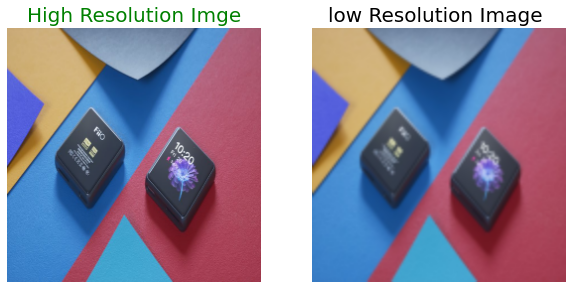

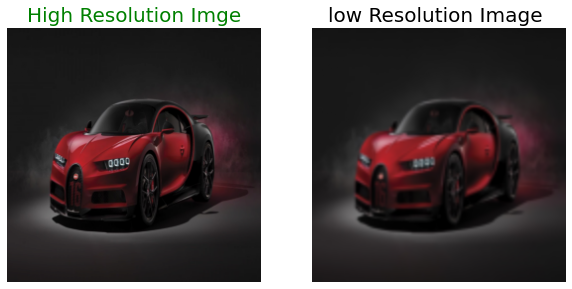

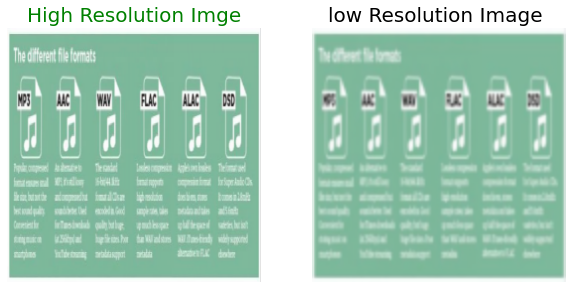

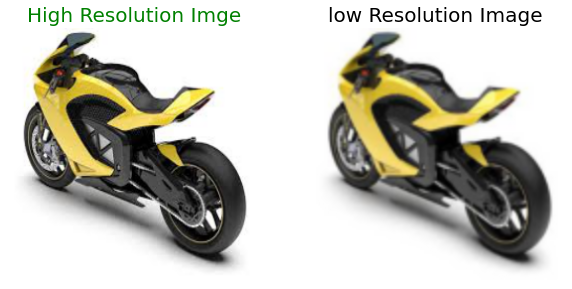

In [3]:
for i in range(4):
    a = np.random.randint(0,100)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# Model Building 

In [5]:
input_shape =Input(shape=(256,256,3))
batch_size = 1
kernel_size = 3
dropout = 0.4
n_filters = 64

In [6]:
def Upsample_block(x,ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 1792        input_5[0][0]                    
____________________________________________________________________________________________

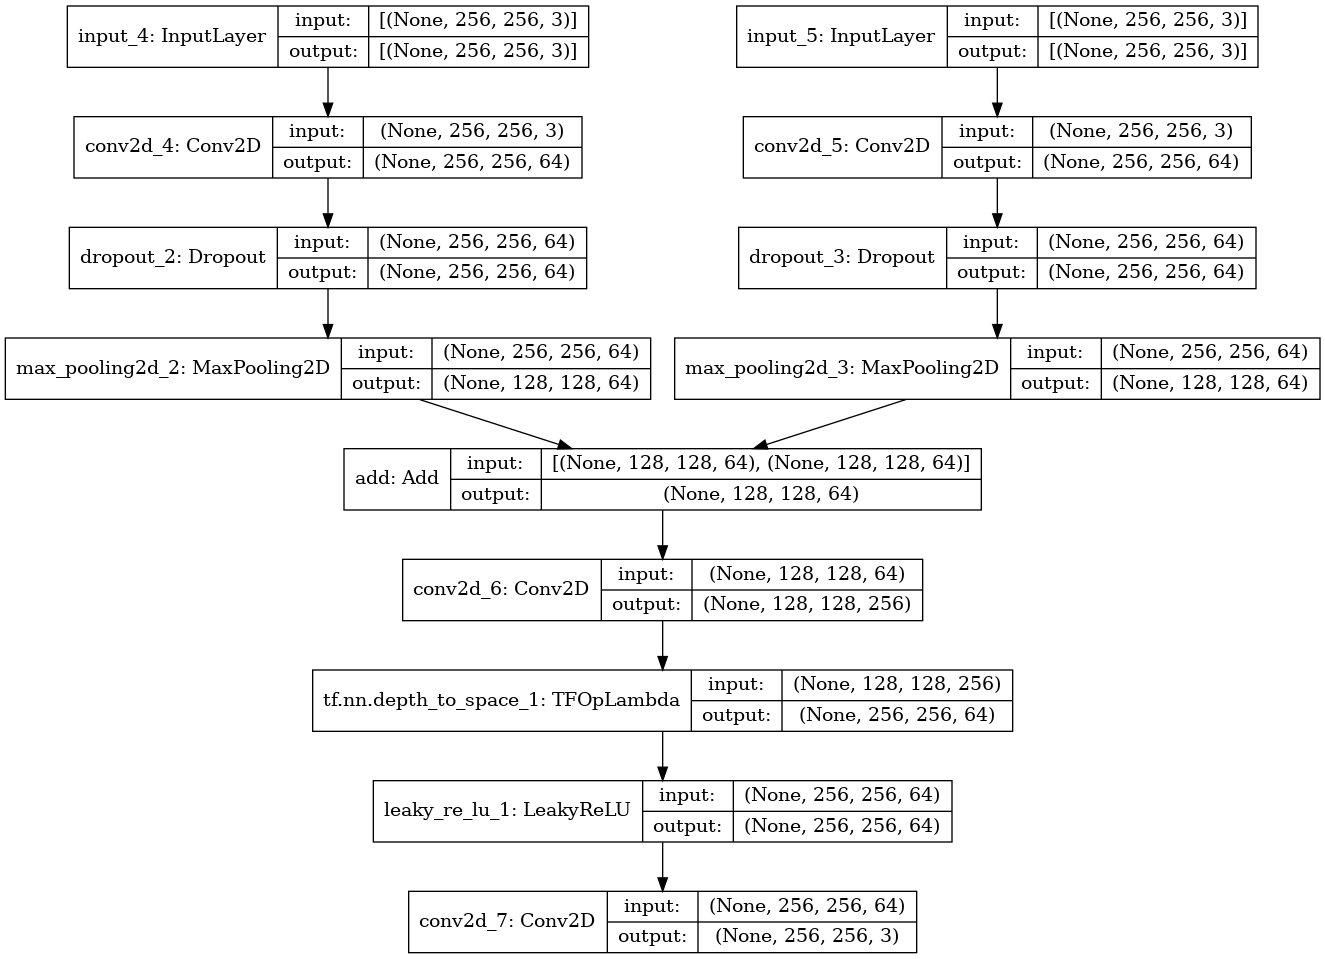

In [22]:
# left branch of Y network
left_inputs = Input(shape=(256,256,3))
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(1):
    x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  padding='same',
                  activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2
    
# left branch of Y network
right_inputs = Input(shape=(256,256,3))
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(1):
    y = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  padding='same',
                  activation='relu')(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

y = add([x, y])
y=Upsample_block(y)
outputs=Conv2D (3,(3,3) , padding='same' ,activation='relu',activity_regularizer=regularizers.l1(10e-10))(y)


Multi_scale_learning= Model([left_inputs, right_inputs], outputs)
Multi_scale_learning.summary()
Multi_scale_learning.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])
plot_model(Multi_scale_learning, to_file='Multi_scale_learning.png', show_shapes=True)

In [23]:
Multi_scale_learning.fit([train_low_image, train_low_image],
             train_high_image,
             validation_data=([validation_low_image, validation_low_image], validation_high_image),
             epochs=20,
             batch_size=batch_size)

Epoch 1/20
700/700 [==============================] - 6s 8ms/step - loss: 0.0500 - acc: 0.7211 - val_loss: 0.1440 - val_acc: 0.7627
Epoch 2/20
700/700 [==============================] - 5s 8ms/step - loss: 0.0331 - acc: 0.7646 - val_loss: 0.1452 - val_acc: 0.7858
Epoch 3/20
700/700 [==============================] - 5s 8ms/step - loss: 0.0334 - acc: 0.7855 - val_loss: 0.1327 - val_acc: 0.8399
Epoch 4/20
700/700 [==============================] - 6s 8ms/step - loss: 0.0275 - acc: 0.8044 - val_loss: 0.1314 - val_acc: 0.8019
Epoch 5/20
700/700 [==============================] - 5s 8ms/step - loss: 0.0284 - acc: 0.8005 - val_loss: 0.1283 - val_acc: 0.8584
Epoch 6/20
700/700 [==============================] - 6s 8ms/step - loss: 0.0277 - acc: 0.8032 - val_loss: 0.1367 - val_acc: 0.8377
Epoch 7/20
700/700 [==============================] - 5s 8ms/step - loss: 0.0281 - acc: 0.8092 - val_loss: 0.1208 - val_acc: 0.7780
Epoch 8/20
700/700 [==============================] - 5s 8ms/step - loss: 0.

In [24]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1 / (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

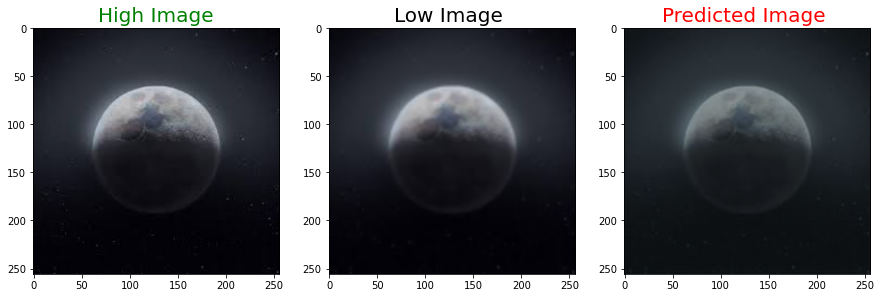

PSNR tf.Tensor(25.632309, shape=(), dtype=float32)


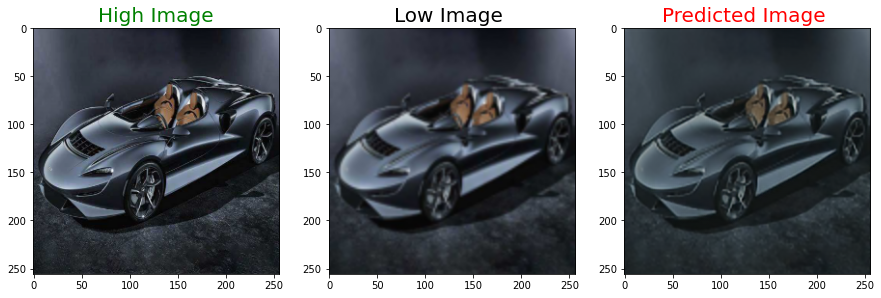

PSNR tf.Tensor(23.698198, shape=(), dtype=float32)


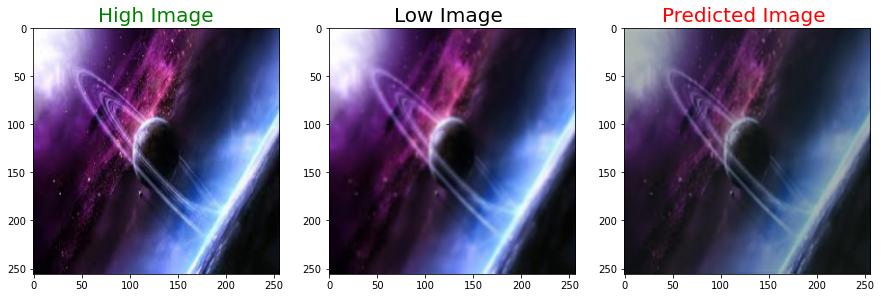

PSNR tf.Tensor(18.536676, shape=(), dtype=float32)


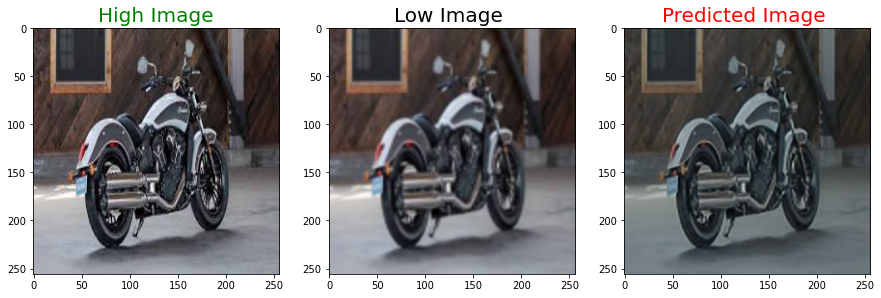

PSNR tf.Tensor(19.40301, shape=(), dtype=float32)


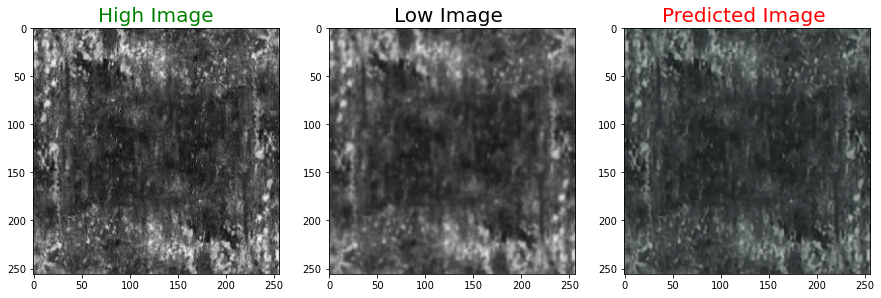

PSNR tf.Tensor(21.990276, shape=(), dtype=float32)


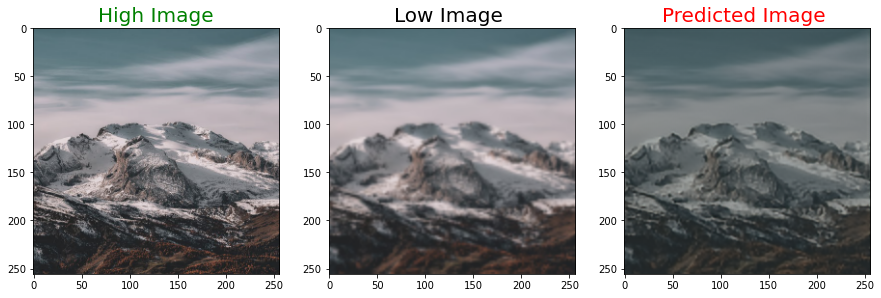

PSNR tf.Tensor(17.599573, shape=(), dtype=float32)


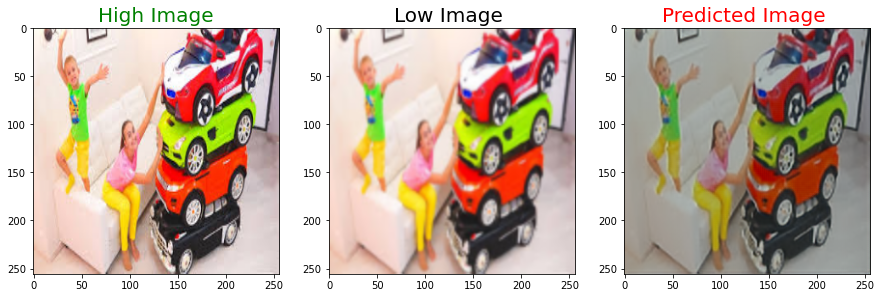

PSNR tf.Tensor(13.110743, shape=(), dtype=float32)


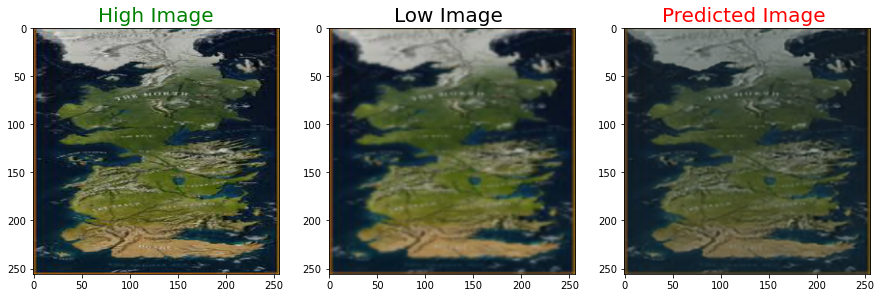

PSNR tf.Tensor(21.321152, shape=(), dtype=float32)


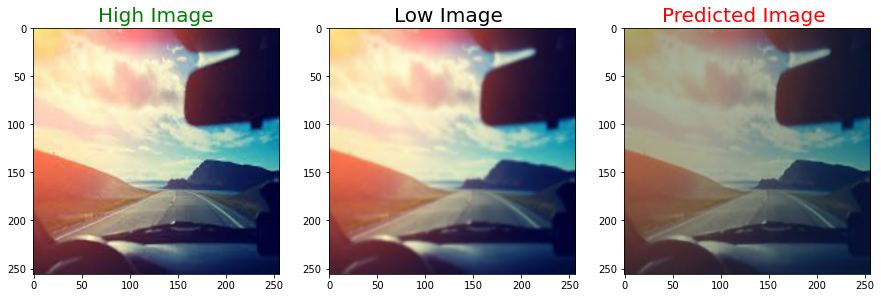

PSNR tf.Tensor(15.274712, shape=(), dtype=float32)


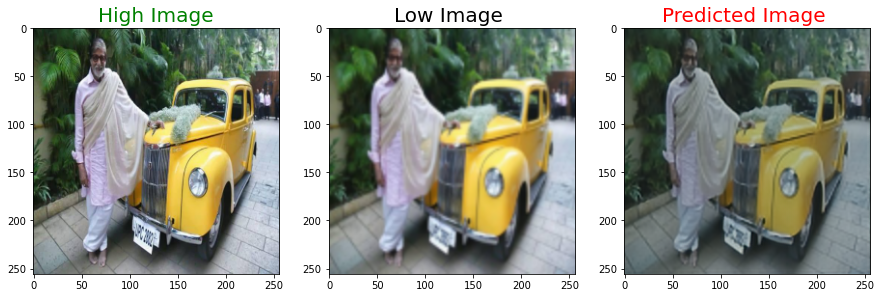

PSNR tf.Tensor(16.599194, shape=(), dtype=float32)


In [25]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(10,20):
    
    predicted = np.clip(Multi_scale_learning.predict([test_low_image[i].reshape(1,SIZE, SIZE,3),test_low_image[i].reshape(1,SIZE, SIZE,3)]),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('PSNR', PSNR(test_high_image[i],predicted))

In [26]:
def downsample_image(image,scale):
    x=tf.image.resize(image / 255,(image.shape[0]//scale, image.shape[1]//scale))
    x=tf.image.resize(x,(image.shape[0], image.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
    return x

In [27]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '../input/set5-hr-lr/Set5/HR'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '5.png':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '../input/set5-hr-lr/Set5/LR/bicubic/x3'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '5.png':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = downsample_image(img,4)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        #img = downsample_image(img,2)
        low_img.append(img_to_array(img))
        
sett_high_image = high_img[1:]
sett_low_image = low_img[1:]
sett_high_image= np.reshape(sett_high_image,(len(sett_high_image),SIZE, SIZE,3))
sett_low_image = np.reshape(sett_low_image,(len(sett_low_image),SIZE,SIZE,3))

100%|██████████| 5/5 [00:00<00:00, 429.23it/s]


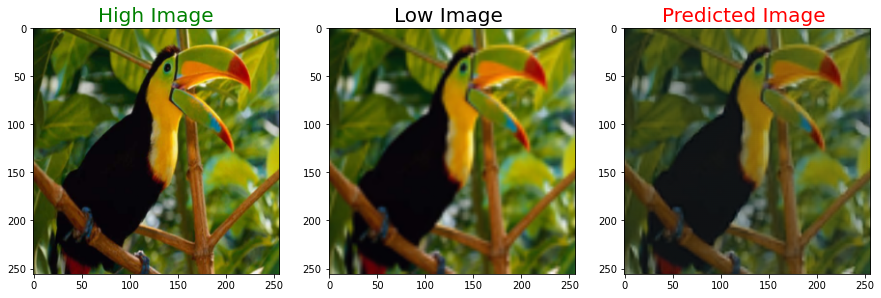

PSNR tf.Tensor(20.770626, shape=(), dtype=float32) dB SSIM tf.Tensor(0.7451063, shape=(), dtype=float32)


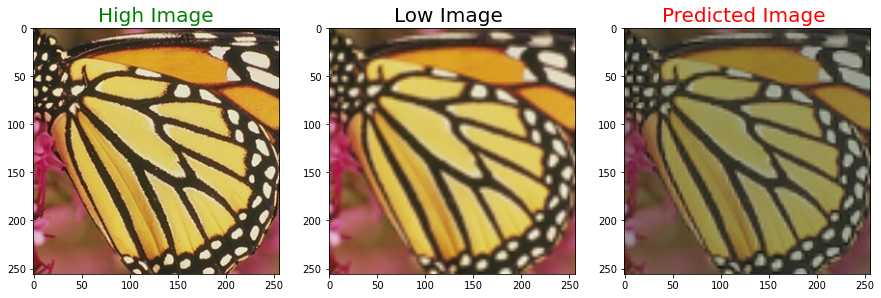

PSNR tf.Tensor(15.531279, shape=(), dtype=float32) dB SSIM tf.Tensor(0.6862151, shape=(), dtype=float32)


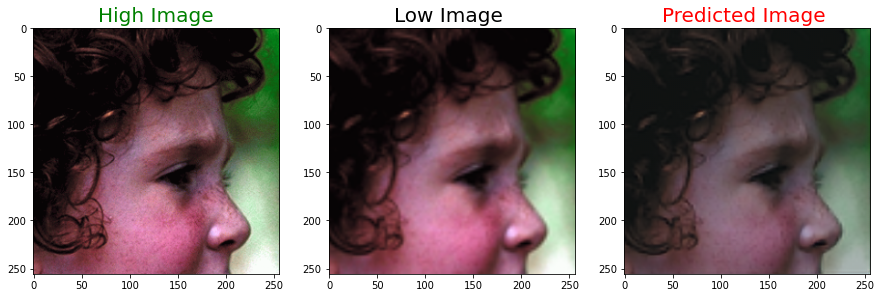

PSNR tf.Tensor(19.103813, shape=(), dtype=float32) dB SSIM tf.Tensor(0.67817944, shape=(), dtype=float32)


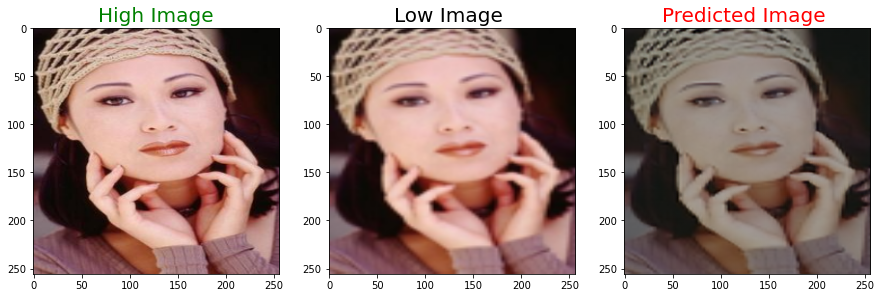

PSNR tf.Tensor(15.663904, shape=(), dtype=float32) dB SSIM tf.Tensor(0.76240236, shape=(), dtype=float32)


In [28]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(0,4):
    
    predicted = np.clip(Multi_scale_learning.predict([sett_low_image[i].reshape(1,SIZE, SIZE,3),sett_low_image[i].reshape(1,SIZE, SIZE,3)]),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(sett_high_image[i],sett_low_image[i],predicted)
    print('PSNR',PSNR(sett_high_image[i],predicted),'dB',"SSIM",tf.image.ssim(sett_high_image[i],predicted,max_val=1))